<a href="https://colab.research.google.com/github/EstebanCabreraArbizu/Trabajo_academico-Machine_Learning/blob/main/TF_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP-Trabajo Parcial / Final
## Objetivo
* Redactar la descripción y fundamentación de la situación real,
utilizando como fuentes los informes correspondientes a las Tareas Académicas 1 y 2 (TA1/TA2).
* Cada grupo obtendrá los datos según requerimiento del Científico de Datos, a partir de
distintas fuentes/origen propuestas (ver detalle en Anexo 1)
## Integrantes:
* Esteban Fabricio Cabrera Arbizu
* Marcelo Guerrero

## Adquisición y Preprocesamientos de los Datos

In [ ]:
import requests

def get_all_categories():
    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/categories"
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': 'd7467015-2757-4138-8cea-04372117e884',
    }

    response = requests.get(url, headers=headers)
    data = response.json()

    return data

def get_related_categories(category):
    all_categories = get_all_categories()
    related_categories = []
    if all_categories and 'data' in all_categories:
      related_categories = [cat['name'] for cat in all_categories['data'] if category in cat['name']]

    return related_categories

category = 'Gaming'  # Reemplaza esto con la categoría que deseas consultar
data = get_related_categories(category)
print(data)


['Gaming Guild', 'Gaming']


In [ ]:
import asyncio
import nest_asyncio
from aiohttp import ClientSession, ClientResponseError
from tqdm.asyncio import tqdm

# Apply nest_asyncio for compatibility with environments that have a running loop
nest_asyncio.apply()
global_cryptos_info = None
# API details
BASE_URL = "https://pro-api.coinmarketcap.com/"
API_KEY = "d7467015-2757-4138-8cea-04372117e884"
HEADERS = {
    "X-CMC_PRO_API_KEY": API_KEY,
    "Accept": "application/json",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

async def fetch_crypto_data(session, endpoint):
    """ Fetches data from the given API endpoint with specified parameters. """
    url = f"{BASE_URL}{endpoint}"
    try:
        async with session.get(url, headers=HEADERS) as response:
            response.raise_for_status()  # This will raise an exception for HTTP error responses
            data = await response.json()
            print("API Response:", data)  # Debugging output to inspect the raw API response
            return data
    except ClientResponseError as e:
        print(f"Failed to fetch data: {e}")
        return None

async def get_related_categories(session, categories):
    endpoint = "v1/cryptocurrency/categories"
    all_categories = await fetch_crypto_data(session, endpoint)
    related_categories = []
    if all_categories and "data" in all_categories:
      for category in categories:
        related_categories.extend([cat['name'] for cat in all_categories["data"] if category in cat['name']])

    return related_categories

async def filter_cryptos_by_category(session, categories):
    """ Filters cryptocurrencies by specified categories after fetching them. """
    endpoint = "v1/cryptocurrency/categories"
    data = await fetch_crypto_data(session, endpoint)
    filtered_ids = set()

    if data and "data" in data:
        for category in data['data']:
            if category["name"] in categories:
                filtered_ids.add(category["id"])

    return filtered_ids

async def obtain_crypto_ids(session, id_c):
    endpoint = "v1/cryptocurrency/category"
    params = {"id": str(id_c)}
    url = f"{BASE_URL}{endpoint}"
    yield_ids = set()
    try:
        async with session.get(url, headers = HEADERS, params = params) as response:
            response.raise_for_status()
            data = await response.json()
            name = data["data"]["name"]
            for i in data["data"]["coins"]:
                id = i["id"]
                if id not in yield_ids:
                    yield_ids.add(id)
            return yield_ids, name
    except ClientResponseError as e:
        print(f"Failed to fetch data: {e}")
        return None

async def get_crypto_data(crypto_id, category):
    url = f"{BASE_URL}v1/cryptocurrency/quotes/latest"
    async with ClientSession() as session:
        try:
            async with session.get(url, params={"id": str(crypto_id)}, headers=HEADERS) as response:
                response.raise_for_status()
                await asyncio.sleep(5)  # Espera 5 segundos entre las solicitudes
                data_quotes = await response.json()  # Esperar la respuesta JSON
                if "data" in data_quotes and str(crypto_id) in data_quotes["data"]:
                    quote_data = data_quotes["data"][str(crypto_id)]["quote"]["USD"]
                    valor_activo_usd = quote_data["price"]
                    capitalizacion_total_mercado = quote_data["market_cap"]
                    posicion_en_ranking = data_quotes["data"][str(crypto_id)]["cmc_rank"]
                    volumen_24h = quote_data["volume_24h"]
                    porcentaje_volumen_diario = quote_data["percent_change_24h"]
                    suministro_circulante = data_quotes["data"][str(crypto_id)]["circulating_supply"]
                    suministro_total = data_quotes["data"][str(crypto_id)]["total_supply"]
                    suministro_maximo = data_quotes["data"][str(crypto_id)]["max_supply"]

                    required_data = {
                        'Coin ID': crypto_id,
                        'Valor del activo (en US$)': valor_activo_usd,
                        'Capitalización total de mercado (market cap)': capitalizacion_total_mercado,
                        'Volumen (volumen 24h)': volumen_24h,
                        'Porcentaje del volumen diario (volumen 24h / market cap)': porcentaje_volumen_diario,
                        'Suministro circulante (circulating supply)': suministro_circulante,
                        'Suministro total (total supply)': suministro_total,
                        'Suministro máximo (max supply)': suministro_maximo,
                        'Posición en ranking': posicion_en_ranking,
                        'Categoría': category
                    }
                    return required_data
                else:
                    print(f"No se encontraron datos para el crypto ID {crypto_id}")
                    return None
        except ClientResponseError as cre:
            print(f"Error en la respuesta del cliente: {cre}")
            return None


async def filter_quotes_by_category_async(crypto_ids, categories):
    async with ClientSession() as session:
        try:
            information = []
            for label, i in zip(categories, crypto_ids):
                for enum in i:
                    quotes_data = await get_crypto_data(enum, label)
                    if quotes_data != None:
                        information.append(quotes_data)
            return information
        except ClientResponseError as cre:
            print(f"Client response error occurred: {cre}")
            return None, None


async def main():
    global global_cryptos_info
    categories = ['Memes', 'Gaming', 'AI']  # Desired categories
    async with ClientSession() as session:
        related_categories = await get_related_categories(session, categories)
        category_ids = await filter_cryptos_by_category(session, related_categories)
        category_ids = list(category_ids)
        print("Filtered Category IDs:", category_ids, "type: ", type(category_ids))
        ids = []
        names = []
        for id in category_ids:
            crypto_id, name = await obtain_crypto_ids(session, id)
            crypto_id = list(crypto_id)
            ids.append(crypto_id)
            names.append(name)
        print(f"Filtered IDs: {ids}")
        print(f"Names of category: {names}")

        # Filtrar y guardar la información importante
        cryptos_info = await filter_quotes_by_category_async(ids, related_categories)
        print("Filtered Cryptos Information:", cryptos_info)
        global_cryptos_info = cryptos_info
    info = cryptos_info
if __name__ == "__main__":
    asyncio.run(main())
print(global_cryptos_info)

API Response: {'status': {'timestamp': '2024-05-16T14:41:42.333Z', 'error_code': 0, 'error_message': None, 'elapsed': 391, 'credit_count': 1, 'notice': None}, 'data': [{'id': '663dd07040575e0870396c23', 'name': 'Rehypothecated Crypto', 'title': 'Rehypothecated Crypto', 'description': 'Rehypothecated Crypto', 'num_tokens': 7, 'avg_price_change': 0.45195145428571426, 'market_cap': 46022586270.909996, 'market_cap_change': 1.6050428571428572, 'volume': 2069073252.1429944, 'volume_change': 75.31728571428573, 'last_updated': '2024-05-10T07:47:43.754Z'}, {'id': '6634dccba7b6f0637eec196a', 'name': 'Fiat Stablecoin', 'title': 'Fiat Stablecoin', 'description': 'Fiat Stablecoin', 'num_tokens': 26, 'avg_price_change': 0.07405850000000001, 'market_cap': 149544091068.15002, 'market_cap_change': 0.400492, 'volume': 84221497266.18092, 'volume_change': 110.00838399999999, 'last_updated': '2024-05-03T12:48:28.586Z'}, {'id': '662609299f284617d8cebc59', 'name': 'EigenLayer Ecosystem', 'title': 'EigenLayer

In [ ]:
import pandas as pd
df = pd.DataFrame(global_cryptos_info)
df

,Coin ID,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Suministro máximo (max supply),Posición en ranking,Categoría
0,28675,2.526435e-06,1.753851e+08,7.915800e+06,1.582203,6.942000e+13,6.942000e+13,6.942000e+13,302.0,Presale Memes
1,27659,6.515298e-07,2.544681e+08,1.704233e+07,7.240401,3.905702e+14,3.905702e+14,4.206900e+14,246.0,Presale Memes
2,28179,7.061642e-03,1.338794e+07,2.520927e+06,-10.600668,1.895867e+09,1.897362e+09,2.000000e+09,1011.0,Presale Memes
3,10269,1.610426e-03,4.107930e+06,2.506522e+05,-13.221461,2.550835e+09,2.775346e+09,NaN,1377.0,Presale Memes
4,10275,5.363435e-10,1.897947e+07,1.220075e+06,0.188068,3.538679e+16,3.678408e+16,1.000000e+17,881.0,Presale Memes
...,...,...,...,...,...,...,...,...,...,...
398,15588,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+09,1.000000e+09,NaN,Generative AI
399,30963,3.736558e-02,1.372503e+08,3.313680e+07,-7.507791,3.673175e+09,1.000000e+10,1.000000e+10,353.0,Generative AI
400,29920,2.868735e-01,1.434361e+08,6.857460e+07,-2.389958,4.999978e+08,4.999978e+08,4.999978e+08,341.0,AI & Big Data
401,30109,1.368101e-02,0.000000e+00,5.704192e+06,-0.452307,0.000000e+00,9.999680e+08,NaN,2584.0,AI & Big Data


In [ ]:
df.to_csv('cryptos_info.csv', index=False)

## Exploración de los datos

In [ ]:
import numpy as np                # linear algebra
import pandas as pd               # data frames
import seaborn as sns             # visualizations
import matplotlib.pyplot as plt   # visualizations
import scipy.stats                # statistics
from scipy import stats

df = pd.read_csv('cryptos_info.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 10 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Coin ID                                                   403 non-null    int64  
 1   Valor del activo (en US$)                                 390 non-null    float64
 2   Capitalización total de mercado (market cap)              390 non-null    float64
 3   Volumen (volumen 24h)                                     403 non-null    float64
 4   Porcentaje del volumen diario (volumen 24h / market cap)  403 non-null    float64
 5   Suministro circulante (circulating supply)                403 non-null    float64
 6   Suministro total (total supply)                           403 non-null    float64
 7   Suministro máximo (max supply)                            294 non-null    float64
 8   Posición en ranking 

In [ ]:
df.shape

(403, 10)

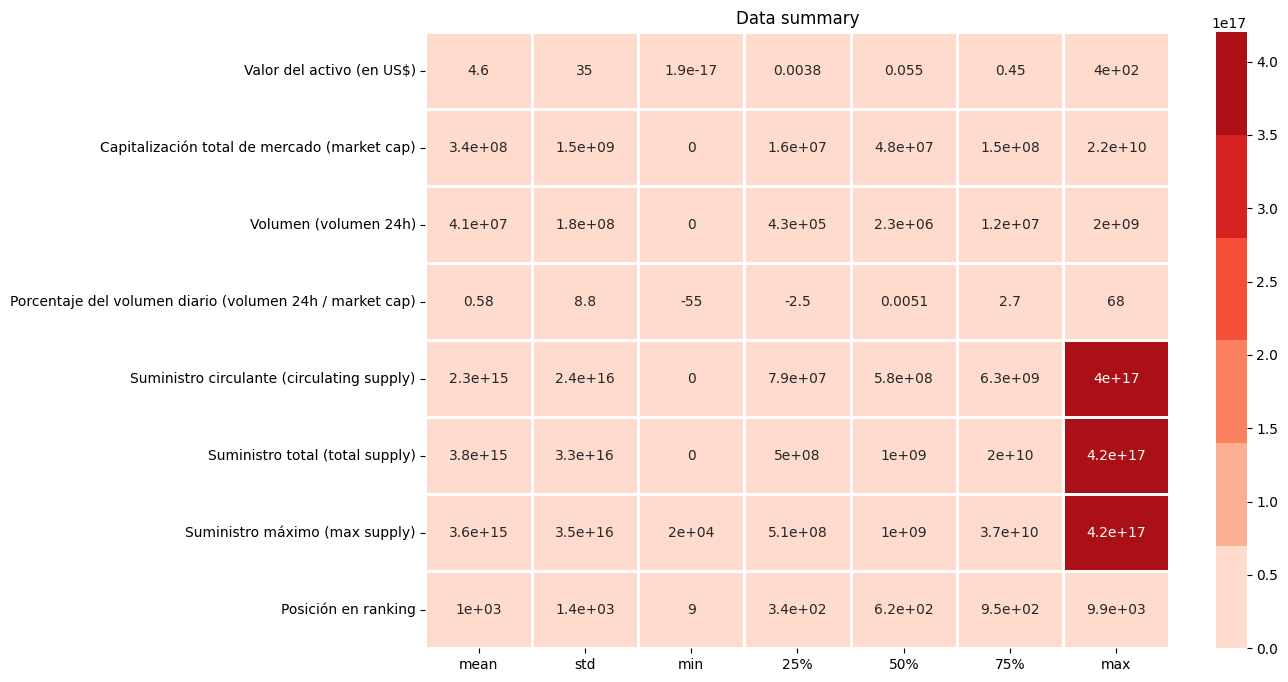

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df.iloc[:,1:].describe()[1:].transpose(),
            annot=True,linecolor="w",
            linewidth=2,cmap=sns.color_palette("Reds"))
plt.title("Data summary")
plt.show()

<ipython-input-8-b4bb5ab6776f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df["Capitalización total de mercado (market cap)"], ax=axes[0,0])
<ipython-input-8-b4bb5ab6776f>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df["Volumen (volumen 24h)"], ax=axes[0,1])
<ipython-input-8-b4bb5ab6

<Axes: xlabel='Posición en ranking', ylabel='Density'>

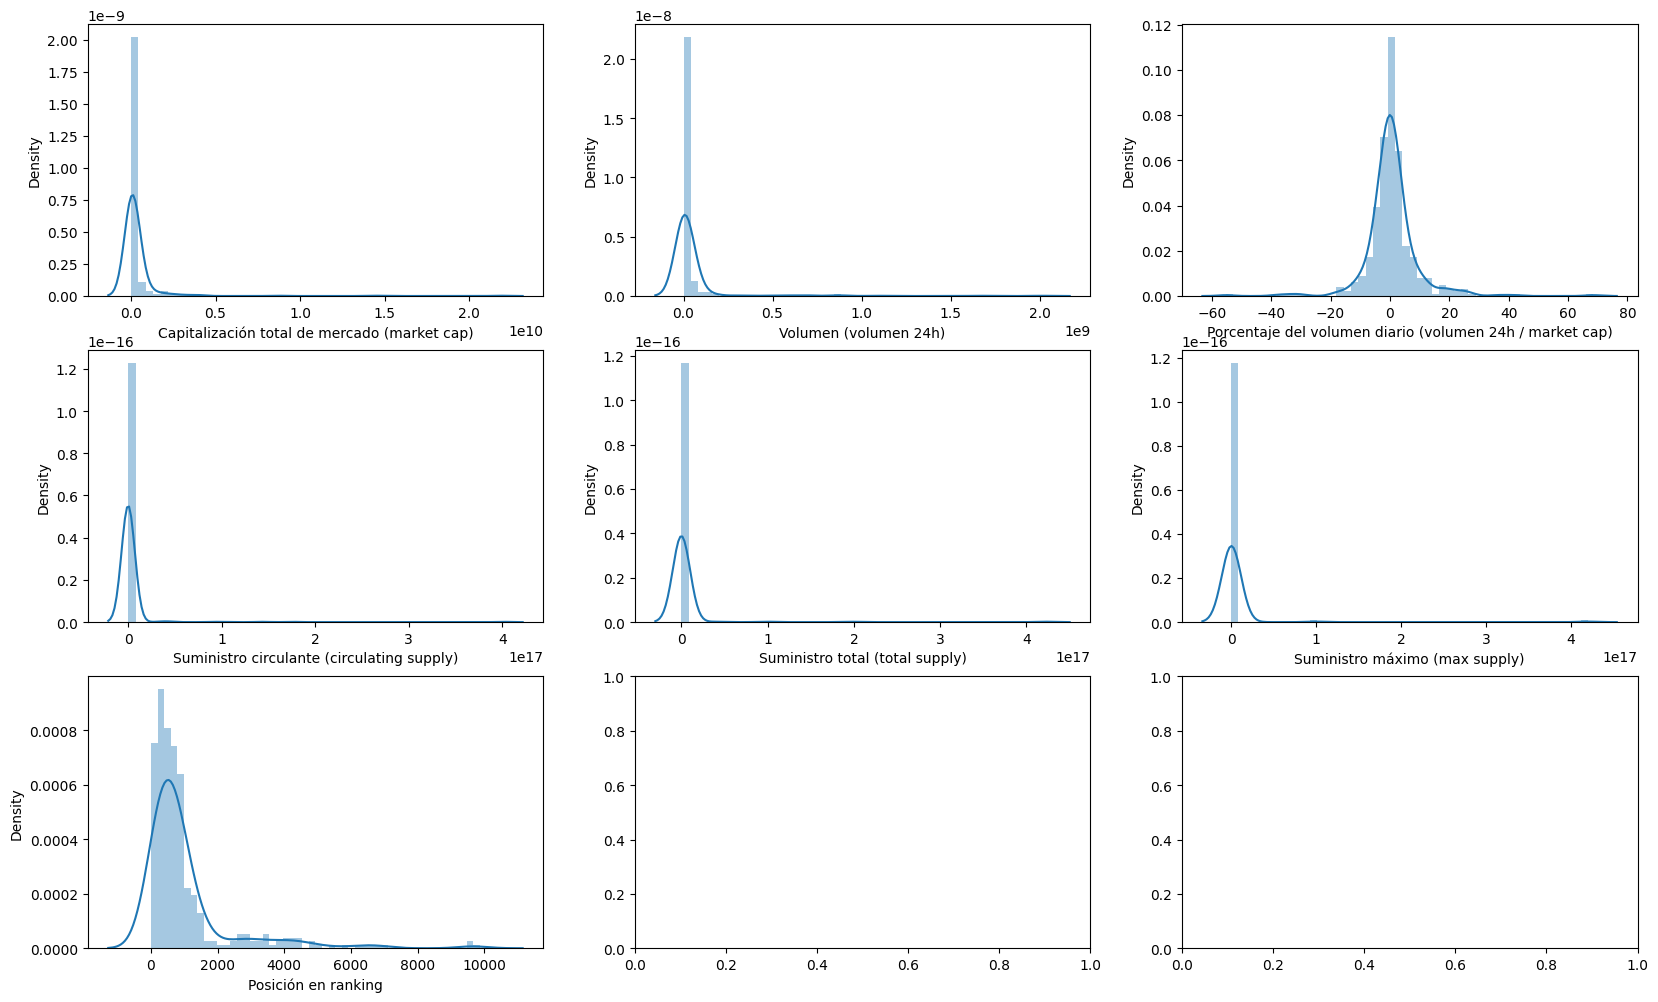

In [ ]:
# Display the histogram to undestand the data
f, axes = plt.subplots(3,3, figsize=(20, 12))
sns.distplot( df["Capitalización total de mercado (market cap)"], ax=axes[0,0])
sns.distplot( df["Volumen (volumen 24h)"], ax=axes[0,1])
sns.distplot( df["Porcentaje del volumen diario (volumen 24h / market cap)"], ax=axes[0,2])
sns.distplot( df["Suministro circulante (circulating supply)"], ax=axes[1,0])
sns.distplot( df["Suministro total (total supply)"], ax=axes[1,1])
sns.distplot( df["Suministro máximo (max supply)"], ax=axes[1,2])
sns.distplot( df["Posición en ranking"], ax=axes[2,0])

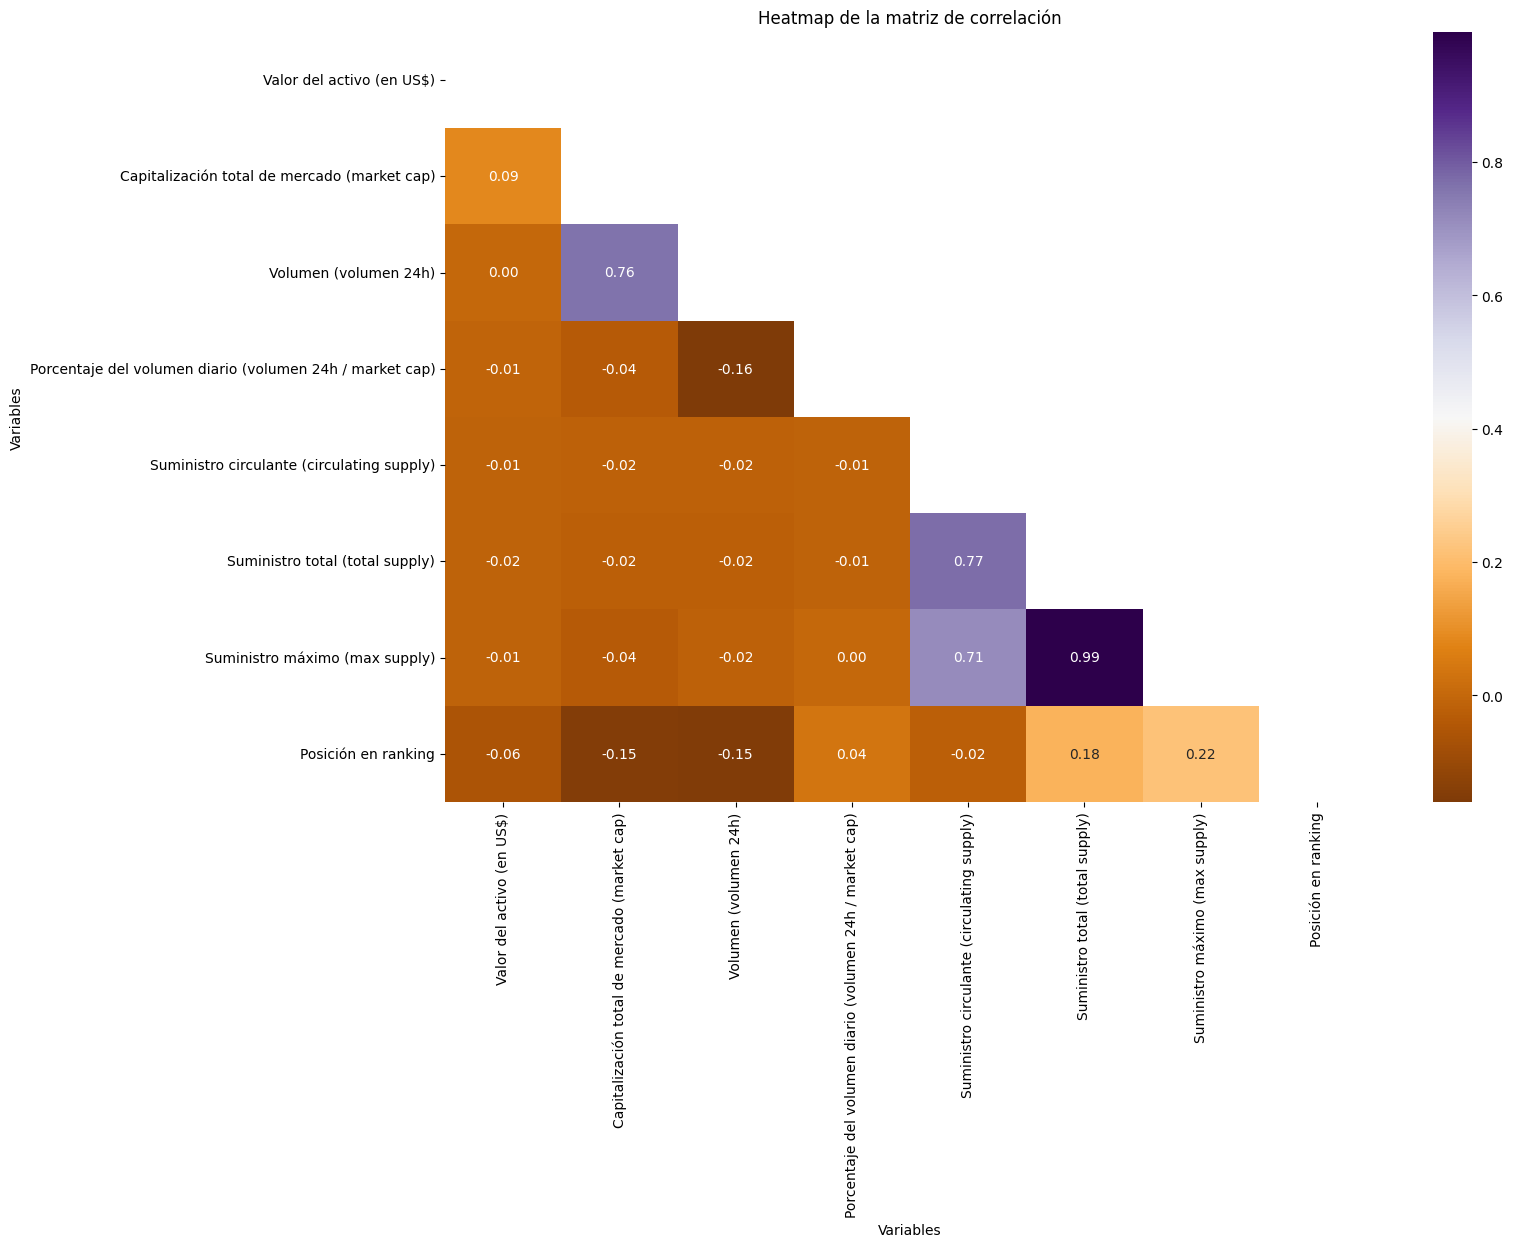

In [ ]:
# Compute the correlation matrix
df_subset = df.iloc[:,1:9]

if df_subset.empty:
    print("Error: El DataFrame está vacío.")
else:
    # Calcular la matriz de correlación
    corr_matrix = df_subset.corr()

    # Comprobar si la matriz de correlación contiene valores NaN
    if corr_matrix.isnull().values.any():
        print("Advertencia: La matriz de correlación contiene valores NaN.")
        print(corr_matrix)
    else:
        # Configurar el tamaño de la figura
        plt.figure(figsize=(15, 10))

        mask = np.zeros_like(corr_matrix, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        # Generar el heatmap de la matriz de correlación
        heatmap = sns.heatmap(data=corr_matrix, mask=mask, cmap="PuOr", annot=True, fmt=".2f")

        # Añadir títulos y etiquetas
        plt.title('Heatmap de la matriz de correlación')
        plt.xlabel('Variables')
        plt.ylabel('Variables')

        # Mostrar la figura
        plt.show()


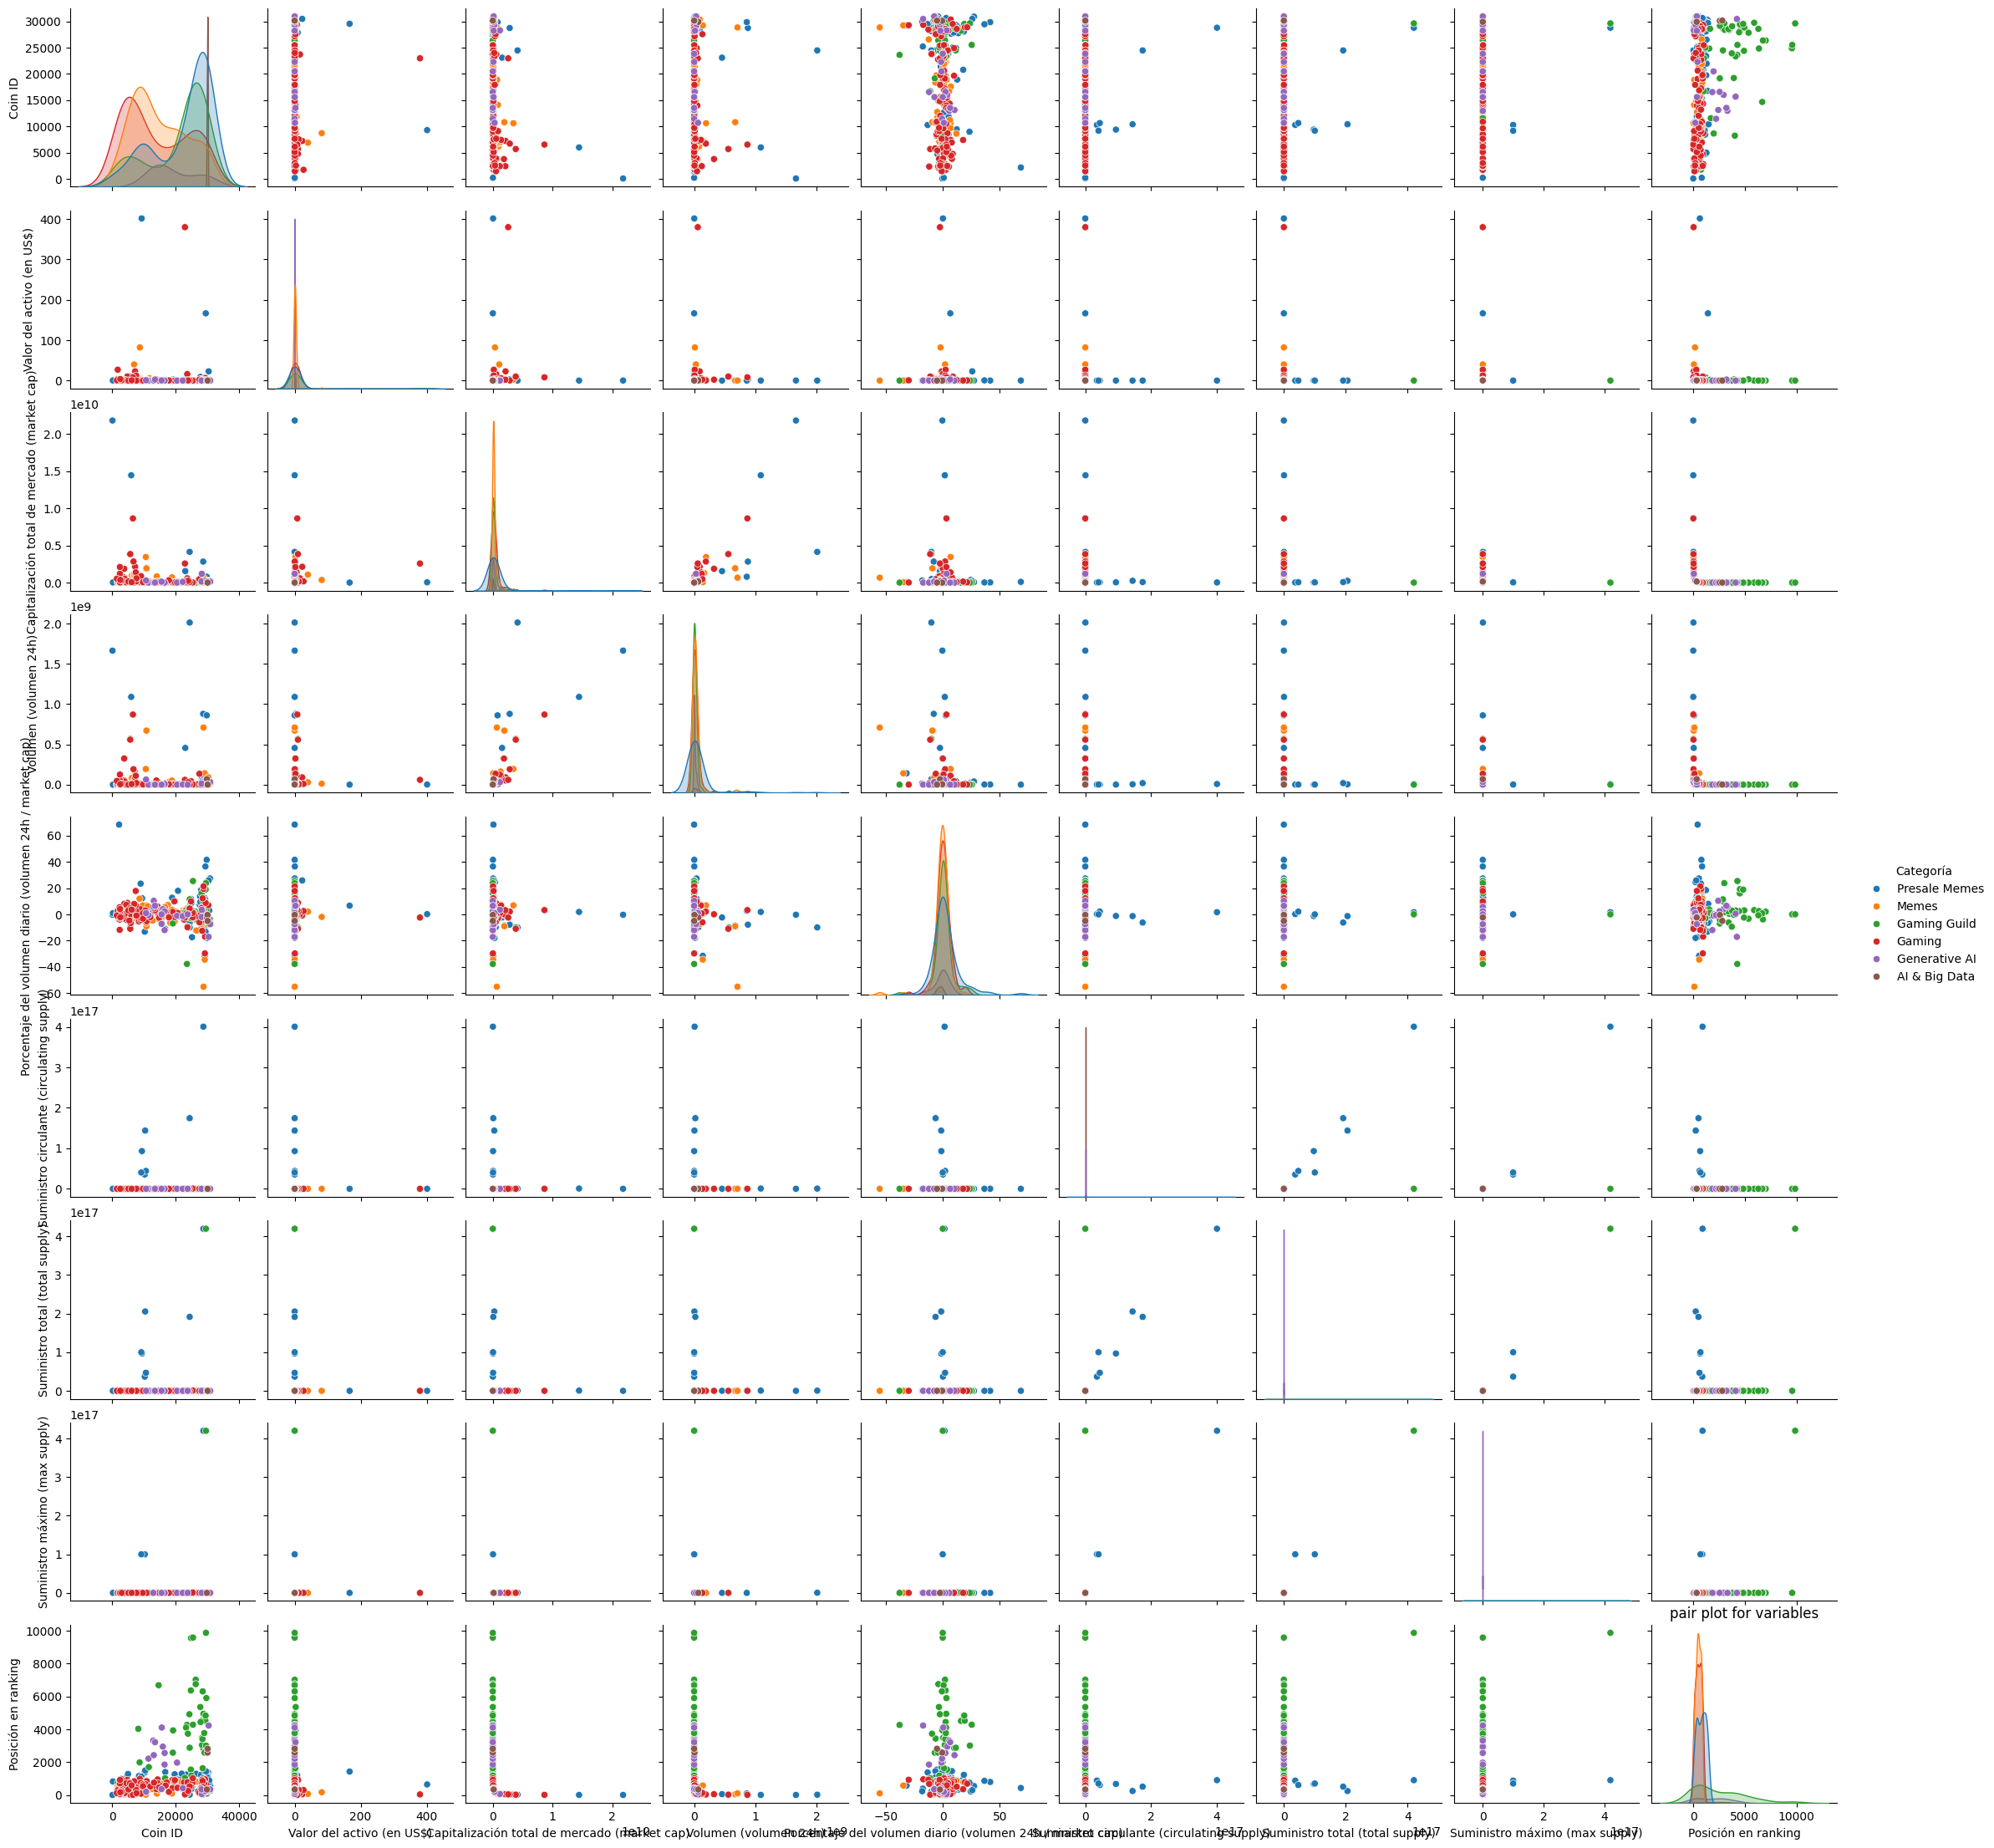

In [ ]:
sns.pairplot(df,hue="Categoría")
plt.title("pair plot for variables")
plt.show()

## Preprosesamiento de los datos

In [ ]:
null_values = df[df.isnull().any(axis=1)]
print("Filas con valores nulos:")
print(null_values)

Filas con valores nulos:
     Coin ID  Valor del activo (en US$)  \
3      10269                   0.001610   
7      10804                   0.000202   
10      9286                 401.305306   
11        74                   0.151219   
12     28752                   2.829355   
..       ...                        ...   
395    13133                   0.000064   
396    13523                   2.451504   
398    15588                        NaN   
401    30109                   0.013681   
402    30157                   0.000761   

     Capitalización total de mercado (market cap)  Volumen (volumen 24h)  \
3                                    4.107930e+06           2.506522e+05   
7                                    1.934274e+09           6.707957e+08   
10                                   4.268180e+07           1.972398e+06   
11                                   2.182308e+10           1.663017e+09   
12                                   2.826260e+09           8.784521e+08   
..

In [ ]:
null_values

,Coin ID,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Suministro máximo (max supply),Posición en ranking,Categoría
3,10269,0.001610,4.107930e+06,2.506522e+05,-13.221461,2.550835e+09,2.775346e+09,NaN,1377.0,Presale Memes
7,10804,0.000202,1.934274e+09,6.707957e+08,-8.506536,9.557507e+12,9.707613e+12,NaN,53.0,Presale Memes
10,9286,401.305306,4.268180e+07,1.972398e+06,0.166015,1.063574e+05,1.075362e+05,NaN,648.0,Presale Memes
11,74,0.151219,2.182308e+10,1.663017e+09,-0.304469,1.443147e+11,1.443147e+11,NaN,9.0,Presale Memes
12,28752,2.829355,2.826260e+09,8.784521e+08,-7.876596,9.989060e+08,9.989060e+08,NaN,40.0,Presale Memes
...,...,...,...,...,...,...,...,...,...,...
395,13133,0.000064,1.443766e+04,4.527223e+04,10.318760,2.266625e+08,3.133843e+08,NaN,2428.0,Generative AI
396,13523,2.451504,0.000000e+00,2.902687e+05,6.511799,0.000000e+00,6.698112e+08,NaN,3217.0,Generative AI
398,15588,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+09,1.000000e+09,NaN,Generative AI
401,30109,0.013681,0.000000e+00,5.704192e+06,-0.452307,0.000000e+00,9.999680e+08,NaN,2584.0,AI & Big Data


In [ ]:
# Para contar los valores nulos en cada columna
null_count = df.isnull().sum()
print("=====================\n")
print("Valores nulos por columna:")
print(null_count)


Valores nulos por columna:
Coin ID                                                       0
Valor del activo (en US$)                                    13
Capitalización total de mercado (market cap)                 13
Volumen (volumen 24h)                                         0
Porcentaje del volumen diario (volumen 24h / market cap)      0
Suministro circulante (circulating supply)                    0
Suministro total (total supply)                               0
Suministro máximo (max supply)                              109
Posición en ranking                                          13
Categoría                                                     0
dtype: int64


In [ ]:
#Verificar proporciones de valores nulos
# Calcular proporciones de valores nulos en cada columna
proporcion_nulos = df.isnull().mean() * 100

# Imprimir las proporciones de valores nulos
print("Proporciones de valores nulos en cada columna:")
print(proporcion_nulos)

Proporciones de valores nulos en cada columna:
Coin ID                                                      0.000000
Valor del activo (en US$)                                    3.225806
Capitalización total de mercado (market cap)                 3.225806
Volumen (volumen 24h)                                        0.000000
Porcentaje del volumen diario (volumen 24h / market cap)     0.000000
Suministro circulante (circulating supply)                   0.000000
Suministro total (total supply)                              0.000000
Suministro máximo (max supply)                              27.047146
Posición en ranking                                          3.225806
Categoría                                                    0.000000
dtype: float64


In [ ]:
# Verificar duplicación de registros u observaciones
duplicados = df.duplicated()
num_duplicados = duplicados.sum()

# Imprimir el número de filas duplicadas
print(duplicados)
print("Número de filas duplicadas:", num_duplicados)

0      False
1      False
2      False
3      False
4      False
       ...  
398    False
399    False
400    False
401    False
402    False
Length: 403, dtype: bool
Número de filas duplicadas: 0


In [ ]:
import numpy as np
#Identificar variables con valores atipicos
# Seleccionar solo las columnas numéricas
df_numericas = df.select_dtypes(include=['int', 'float'])

# Calcular el rango intercuartílico (IQR) para cada columna numérica
Q1 = df_numericas.quantile(0.25)
Q3 = df_numericas.quantile(0.75)
IQR = Q3 - Q1

# Identificar valores atípicos para cada columna numérica
valores_atipicos = ((df_numericas < (Q1 - 1.5 * IQR)) | (df_numericas > (Q3 + 1.5 * IQR))).any()

# Método Z-Score
z_scores = (df_numericas - df_numericas.mean()) / df_numericas.std()
outliers_zscore = (np.abs(z_scores) > 3).any()

# Mostrar las columnas con valores atípicos
columnas_atipicas_iqr = valores_atipicos[valores_atipicos == True].index
print("Columnas con valores atípicos usando IQR:")
print(columnas_atipicas_iqr)
columnas_atipicas_zscore = outliers_zscore[outliers_zscore == True].index
print("Columnas atípicas con z-score:")
print(columnas_atipicas_zscore)

Columnas con valores atípicos usando IQR:
Index(['Valor del activo (en US$)',
       'Capitalización total de mercado (market cap)', 'Volumen (volumen 24h)',
       'Porcentaje del volumen diario (volumen 24h / market cap)',
       'Suministro circulante (circulating supply)',
       'Suministro total (total supply)', 'Suministro máximo (max supply)',
       'Posición en ranking'],
      dtype='object')
Columnas atípicas con z-score:
Index(['Valor del activo (en US$)',
       'Capitalización total de mercado (market cap)', 'Volumen (volumen 24h)',
       'Porcentaje del volumen diario (volumen 24h / market cap)',
       'Suministro circulante (circulating supply)',
       'Suministro total (total supply)', 'Suministro máximo (max supply)',
       'Posición en ranking'],
      dtype='object')


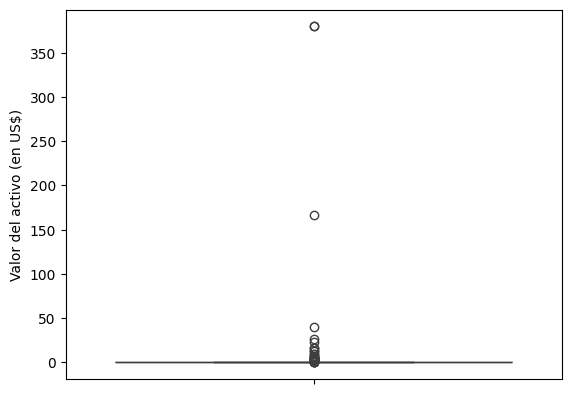

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame df con los datos necesarios

# Manejo de valores faltantes (por ejemplo, eliminar filas con valores faltantes)
df_clean = df.dropna()

# Convertir la columna 'Categoría' en variables dummy si es necesario
df_clean = pd.get_dummies(df_clean, columns=['Categoría'])

# Crear el boxplot usando Seaborn
sns.boxplot(data=df_clean['Valor del activo (en US$)'])

# Rotar los nombres de las columnas para una mejor visualización
#plt.xticks(rotation=270)

# Mostrar el boxplot
plt.show()


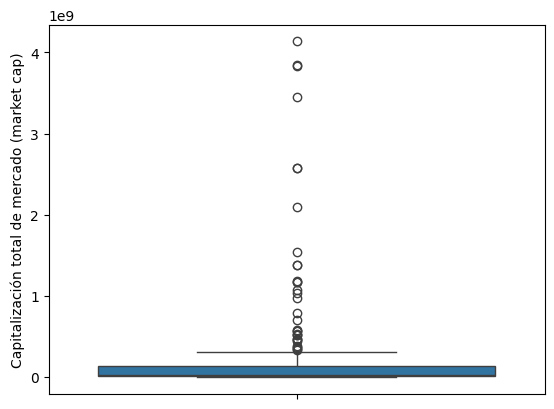

In [ ]:
sns.boxplot(data=df_clean['Capitalización total de mercado (market cap)'])
plt.show()

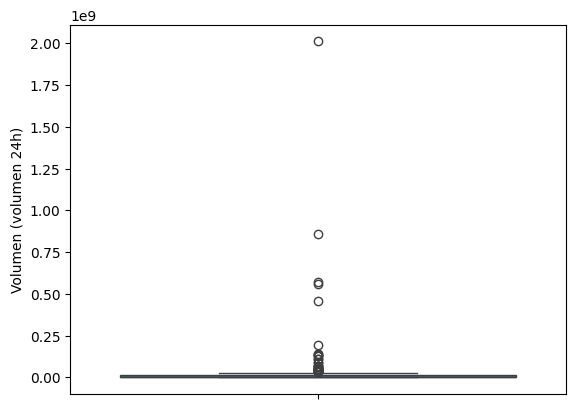

In [ ]:
sns.boxplot(data=df_clean['Volumen (volumen 24h)'])
plt.show()

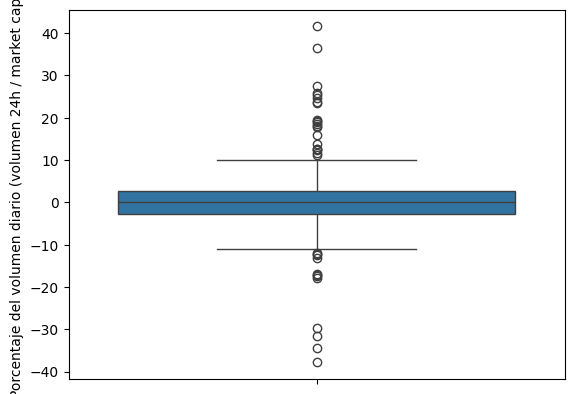

In [ ]:
sns.boxplot(data=df_clean['Porcentaje del volumen diario (volumen 24h / market cap)'])
plt.show()

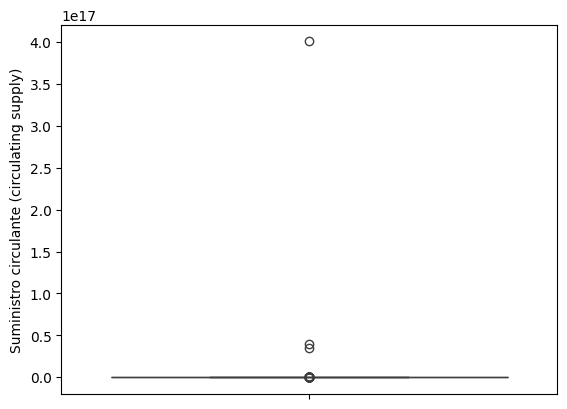

In [ ]:
sns.boxplot(data=df_clean['Suministro circulante (circulating supply)'])
plt.show()

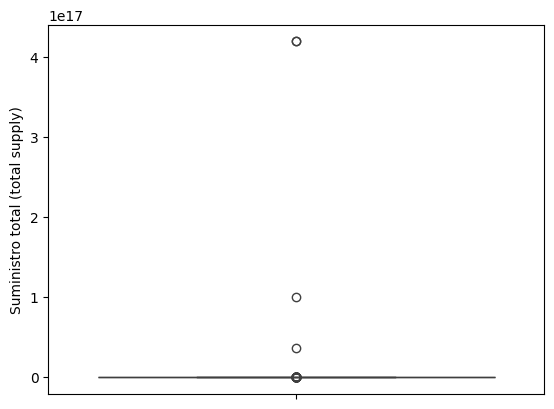

In [ ]:
sns.boxplot(data=df_clean['Suministro total (total supply)'])
plt.show()

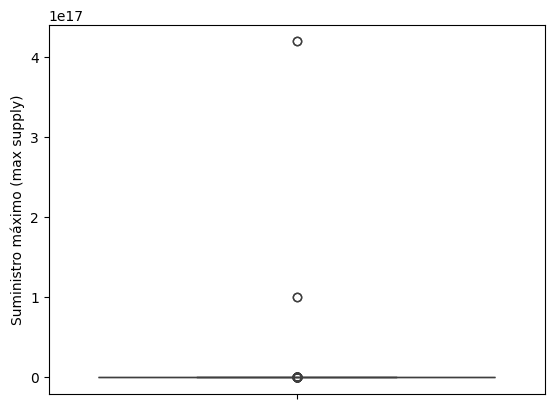

In [ ]:
sns.boxplot(data=df_clean['Suministro máximo (max supply)'])
plt.show()

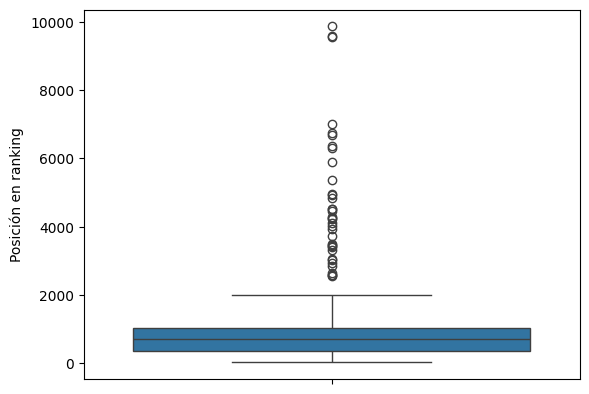

In [ ]:
sns.boxplot(data=df_clean['Posición en ranking'])
plt.show()


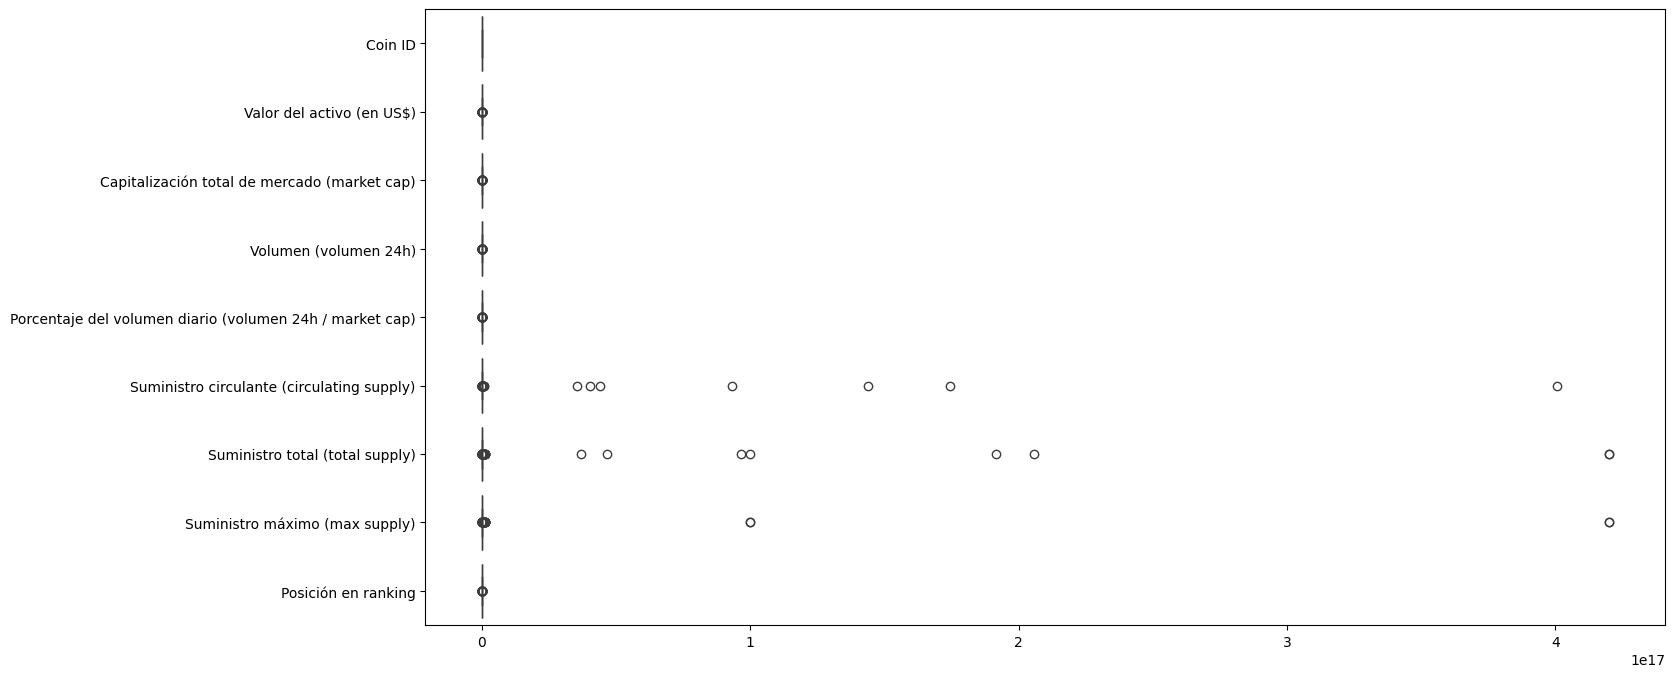

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(df, orient = 'h')
plt.show()

### Limpieza de datos

In [ ]:
df_clean = df.copy()

* Datos Nulos

In [ ]:
mediana = df_clean["Suministro máximo (max supply)"].median()
df_clean["Suministro máximo (max supply)"] = df_clean["Suministro máximo (max supply)"].fillna(mediana)

In [ ]:
print(mediana)

1000000000.0


In [ ]:
#Verificamos que no existan datos faltantes
print("Valores faltantes después de la imputación:")
print(df_clean.isnull().sum())

Valores faltantes después de la imputación:
Coin ID                                                      0
Valor del activo (en US$)                                   13
Capitalización total de mercado (market cap)                13
Volumen (volumen 24h)                                        0
Porcentaje del volumen diario (volumen 24h / market cap)     0
Suministro circulante (circulating supply)                   0
Suministro total (total supply)                              0
Suministro máximo (max supply)                               0
Posición en ranking                                         13
Categoría                                                    0
dtype: int64


* Datos atípicos

In [ ]:
#Prueba de normalidad
#Ho: las variables se aproximan a una distribución normal
#Ha: las variables NO se aproximan a una distribución normal

#pvalue < 5% => Se rechaza la Ho, a un nivel de confianza de 95%,
#la variable no se aproxima a una distribución normal

#pvalue > 5% => No se rechaza la Ho, a un nivel de confianza de 95%,
#la variable se aproxima a una distribución normal
def test_normality(dataframe):
    results = {}

    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            # Realizar el test de Shapiro-Wilk
            stat, p_value = stats.shapiro(dataframe[column].dropna())
            results[column] = {'W': stat, 'p-value': p_value}
        else:
            results[column] = {'W': None, 'p-value': None, 'error': 'Non-numeric column'}

    return results

results = test_normality(df_clean)
for column, result in results.items():
    print(f"Column: {column}")
    if 'error' in result:
        print(f"  Error: {result['error']}")
    else:
        print(f"  W: {result['W']:.4f}")
        print(f"  p-value: {result['p-value']:.4f}")

Column: Coin ID
  W: 0.8923
  p-value: 0.0000
Column: Valor del activo (en US$)
  W: 0.1047
  p-value: 0.0000
Column: Capitalización total de mercado (market cap)
  W: 0.1982
  p-value: 0.0000
Column: Volumen (volumen 24h)
  W: 0.2285
  p-value: 0.0000
Column: Porcentaje del volumen diario (volumen 24h / market cap)
  W: 0.7814
  p-value: 0.0000
Column: Suministro circulante (circulating supply)
  W: 0.0754
  p-value: 0.0000
Column: Suministro total (total supply)
  W: 0.0917
  p-value: 0.0000
Column: Suministro máximo (max supply)
  W: 0.0596
  p-value: 0.0000
Column: Posición en ranking
  W: 0.5942
  p-value: 0.0000
Column: Categoría
  Error: Non-numeric column


In [ ]:
def truncate_outliers(dataset, column):
    # Calcular percentiles y RIC
    percentile25 = dataset[column].quantile(0.25)
    percentile75 = dataset[column].quantile(0.75)
    ric = percentile75 - percentile25

    # Determinar límites superior e inferior
    upper_limit = percentile75 + 1.5 * ric
    lower_limit = percentile25 - 1.5 * ric

    # Aplicar los límites a la columna
    dataset[column] = np.where(
        dataset[column] > upper_limit,
        upper_limit,
        np.where(
            dataset[column] < lower_limit,
            lower_limit,
            dataset[column]
        )
    )
    return dataset

In [ ]:
truncate_outliers(df_clean, 'Valor del activo (en US$)')
truncate_outliers(df_clean, 'Capitalización total de mercado (market cap)')
truncate_outliers(df_clean, 'Volumen (volumen 24h)')
truncate_outliers(df_clean, 'Porcentaje del volumen diario (volumen 24h / market cap)')
truncate_outliers(df_clean, 'Suministro circulante (circulating supply)')
truncate_outliers(df_clean, 'Suministro total (total supply)')
truncate_outliers(df_clean, 'Suministro máximo (max supply)')
truncate_outliers(df_clean, 'Posición en ranking')

,Coin ID,Valor del activo (en US$),Capitalización total de mercado (market cap),Volumen (volumen 24h),Porcentaje del volumen diario (volumen 24h / market cap),Suministro circulante (circulating supply),Suministro total (total supply),Suministro máximo (max supply),Posición en ranking,Categoría
0,28675,2.526435e-06,1.753851e+08,7.915800e+06,1.582203,1.568331e+10,4.870748e+10,9.104730e+10,302.0,Presale Memes
1,27659,6.515298e-07,2.544681e+08,1.704233e+07,7.240401,1.568331e+10,4.870748e+10,9.104730e+10,246.0,Presale Memes
2,28179,7.061642e-03,1.338794e+07,2.520927e+06,-10.408156,1.895867e+09,1.897362e+09,2.000000e+09,1011.0,Presale Memes
3,10269,1.610426e-03,4.107930e+06,2.506522e+05,-10.408156,2.550835e+09,2.775346e+09,NaN,1377.0,Presale Memes
4,10275,5.363435e-10,1.897947e+07,1.220075e+06,0.188068,1.568331e+10,4.870748e+10,9.104730e+10,881.0,Presale Memes
...,...,...,...,...,...,...,...,...,...,...
398,15588,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,1.000000e+09,1.000000e+09,NaN,Generative AI
399,30963,3.736558e-02,1.372503e+08,2.934144e+07,-7.507791,3.673175e+09,1.000000e+10,1.000000e+10,353.0,Generative AI
400,29920,2.868735e-01,1.434361e+08,2.934144e+07,-2.389958,4.999978e+08,4.999978e+08,4.999978e+08,341.0,AI & Big Data
401,30109,1.368101e-02,0.000000e+00,5.704192e+06,-0.452307,0.000000e+00,9.999680e+08,NaN,1876.0,AI & Big Data


In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.histplot(df['Suministro máximo (max supply)'], kde=True)
plt.subplot(2,2,2)
sns.boxplot(df['Suministro máximo (max supply)'], orient = "y")
plt.subplot(2,2,3)
sns.histplot(df_clean['Suministro máximo (max supply)'], kde=True)
plt.subplot(2,2,4)
sns.boxplot(df_clean['Suministro máximo (max supply)'], orient = "y")
plt.show()

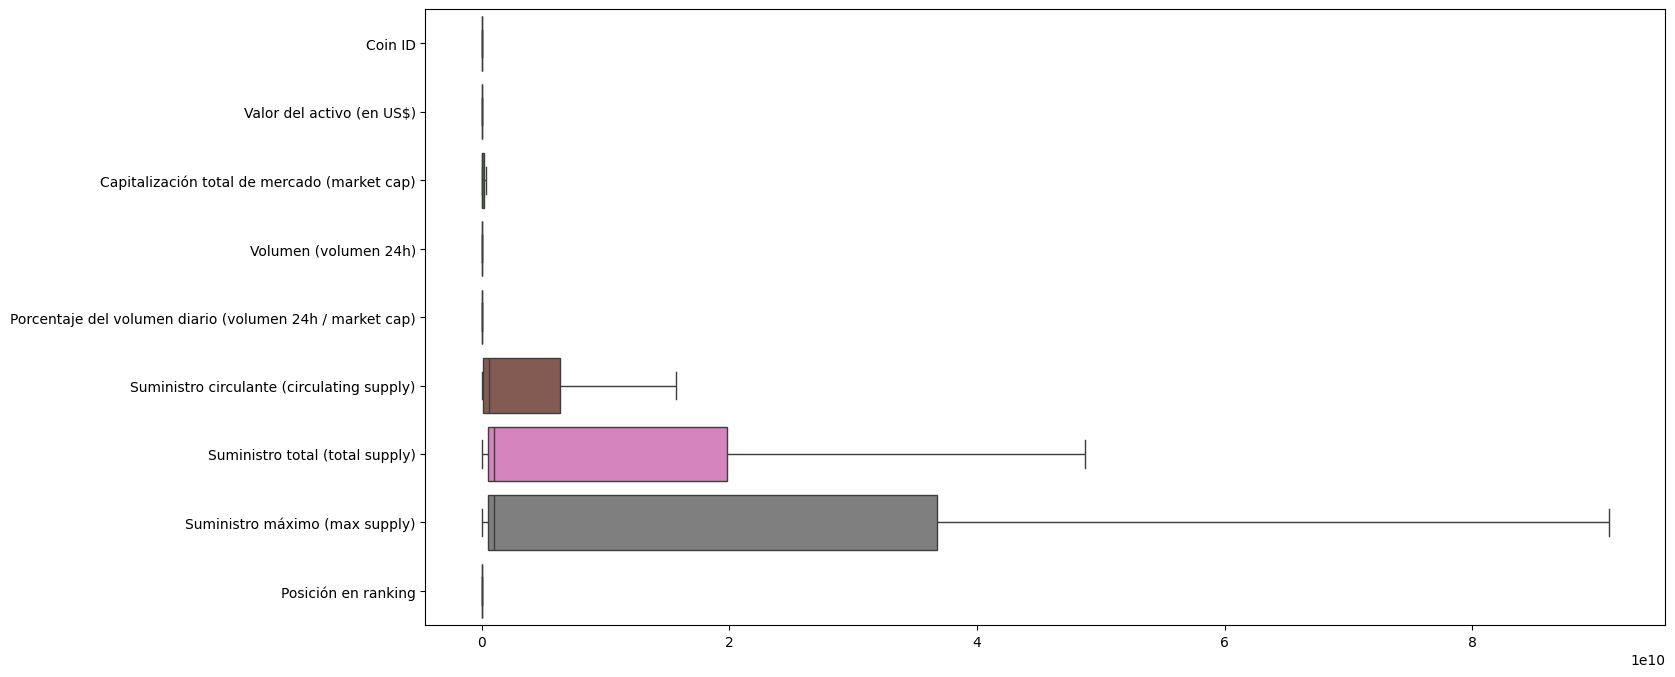

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(df_clean, orient = 'h')
plt.show()

In [ ]:
df_clean.shape

(403, 10)

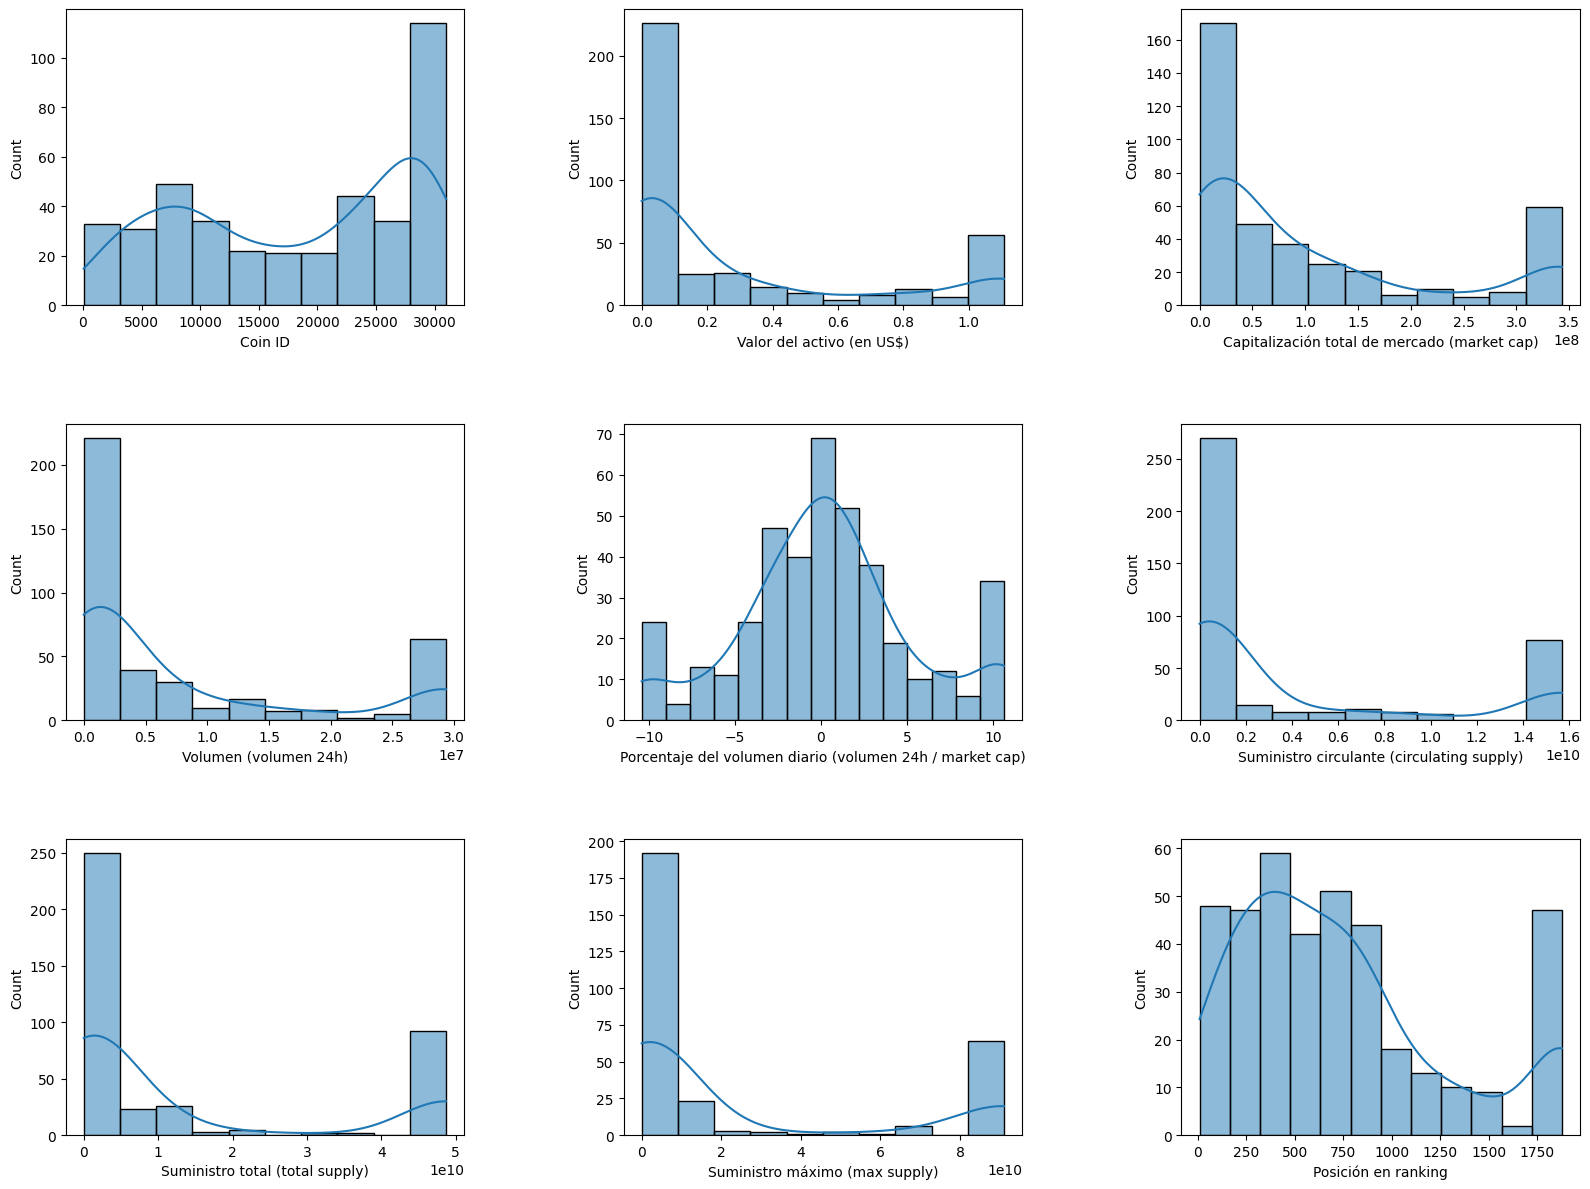

In [ ]:
plt.figure(figsize=(16, 12))
num_cols = len(df_clean.select_dtypes(include='number').columns)
num_rows = (num_cols + 2) // 3  # Calcular el número de filas necesario para una cuadrícula de 3 columnas
num_cols_plot = 3  # Número de columnas en la cuadrícula de gráficos

for i, column in enumerate(df_clean.select_dtypes(include='number').columns):
    plt.subplot(num_rows, num_cols_plot, i + 1)  # Ajustar dinámicamente la cuadrícula de subgráficos
    sns.histplot(df_clean[column], kde=True)  # Usar sns.histplot en lugar de sns.distplot
    plt.tight_layout()  # Ajustar automáticamente el espaciado de subgráficos

plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar el espaciado entre subgráficos
plt.show()


In [ ]:
df_clean.to_csv('cryptos_info_clean.csv', index=False)